# 1. Imports

In [1]:
from data_preparation import *
from preprocessing import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    top_k_accuracy_score,
)

import torchmetrics
from torchmetrics.classification import MulticlassConfusionMatrix


from KANLinear import KANLinear
from KANConv import KAN_Convolutional_Layer

## 1.1 SEED SET

In [2]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

# 2. Data

In [ ]:
path = '/BMIS_EMG_DATA/data/mat_data'
subject_number = 1
end_subject = 33
fs = 200
number_gestures = 4
record_time = 5
train_repetition = [1, 2, 3, 4, 5, 6]
test_repetition = [3, 5]
gesture = [1, 2, 3, 4, 5, 6, 7]
selected_gesture = [1, 2, 3, 4]
num_gesture = len(gesture)

notch_freq=60.0 
low_cut=5.0
high_cut=99.0
order=5

window_time=200 
overlap=60
no_channel=8

batch_size = 32

In [4]:
emg_prep = EMGDataPreparation(base_path=path, fs=fs, rec_time=record_time)
data, labels, _, _ = emg_prep.load_multiple_subject(start_subject=subject_number, end_subject=end_subject, num_gesture=num_gesture, train_repetition=train_repetition, test_repetition=test_repetition, selected_gesture=selected_gesture)
data.shape, labels.shape
# Reorder the labels
# labels[labels == 6] -= 2

((8, 792000), (792000,))

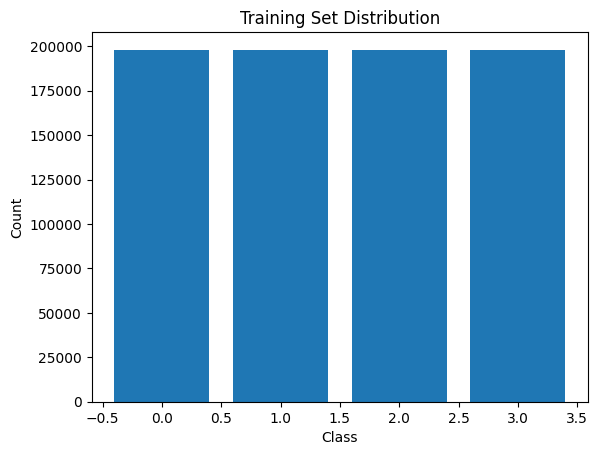

In [5]:
np.unique(labels, return_counts=True)
counts_train = np.unique(labels, return_counts=True)
plt.bar(counts_train[0], counts_train[1])
plt.title('Training Set Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## 2.1. Data Preprocessing

In [6]:
preprocess = EMGPreprocessing(fs=fs, notch_freq=notch_freq, low_cut=low_cut, high_cut=high_cut, order=order)

# Notch filter
data = preprocess.remove_mains(data)

# Bandpass filter
data = preprocess.bandpass_filter(data)

# Windowing
data, labels = emg_prep.window_with_overlap(data, labels, window_time=window_time, overlap=overlap, no_channel=no_channel)
data = np.expand_dims(data, axis=1)

# Normalization
#data = min_max_normalization(data)
# data = scale_data_normalization(data)

In [7]:
# Shuffle the data
data, labels = shuffle_data(data, labels)
train_data, train_labels, test_data, test_labels = data_split(data, labels, train_ratio=80) # 80% train, 20% test   
print(f'The training data shape is {train_data.shape}')
print(f'The testing data shape is {test_data.shape}')
print(f'The maximum value in the training data is {np.max(train_data)}')
print(f'The minimum value in the training data is {np.min(train_data)}')
print(f'The maximum value in the testing data is {np.max(test_data)}')
print(f'The minimum value in the testing data is {np.min(test_data)}')

The training data shape is (39598, 1, 8, 40)
The testing data shape is (9900, 1, 8, 40)
The maximum value in the training data is 210.29960538254858
The minimum value in the training data is -212.77546928384353
The maximum value in the testing data is 183.49144200087304
The minimum value in the testing data is -211.83659438596618


In [8]:
traindataset = EMGDataset(train_data, train_labels)
testdataset = EMGDataset(test_data, test_labels)

train_loader = DataLoader(traindataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testdataset, batch_size=batch_size, shuffle=False)

# 3. EMGFAN Architecture 

In [9]:
class FANLayer(nn.Module):

    
    def __init__(self, input_dim, output_dim, p_ratio=0.25, activation='gelu', use_p_bias=True):
        super(FANLayer, self).__init__()
        
        # Ensure the p_ratio is within a valid range
        assert 0 < p_ratio < 0.5, "p_ratio must be between 0 and 0.5"
        
        self.p_ratio = p_ratio
        p_output_dim = int(output_dim * self.p_ratio)
        g_output_dim = output_dim - p_output_dim * 2  # Account for cosine and sine terms

        # Linear transformation for the p component (for cosine and sine parts)
        self.input_linear_p = nn.Linear(input_dim, p_output_dim, bias=use_p_bias)
        
        # Linear transformation for the g component
        self.input_linear_g = nn.Linear(input_dim, g_output_dim)
        
        # Set the activation function
        if isinstance(activation, str):
            self.activation = getattr(F, activation)
        else:
            self.activation = activation if activation else lambda x: x

    def forward(self, src):
        """
        Args:
            src (Tensor): Input tensor of shape (batch_size, input_dim).
        
        Returns:
            Tensor: Output tensor of shape (batch_size, output_dim), after applying the FAN layer.
        """
        
        # Apply the linear transformation followed by the activation for the g component

        g = self.activation(self.input_linear_g(src))
        
        # Apply the linear transformation for the p component
        p = self.input_linear_p(src)

        # Concatenate cos(p), sin(p), and activated g along the last dimension
        output = torch.cat((torch.cos(p), torch.sin(p), g), dim=-1)

        
        return output

In [10]:
class EMGFAN(nn.Module):
    def __init__(self, input_dim=1, num_gesture=4, similarparameter=False):
        super(EMGFAN, self).__init__()
        self.similarparameter = similarparameter
        self.out_gesture = num_gesture
        self.in_channel = input_dim

        self.conv1 = nn.Conv2d(self.in_channel, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.scalar = lambda x: x*4//3 if self.similarparameter else x
        self.FAN = FANLayer(1152, self.scalar(256))
        self.fc2 = nn.Linear(256, self.out_gesture)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batchnorm1(x) 
        x = self.maxpool2(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.FAN(x)
        x = self.fc2(x)
        return x

In [11]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EMGFAN(1, num_gesture=number_gestures, similarparameter=False)
model = model.cuda()
model

EMGFAN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FAN): FANLayer(
    (input_linear_p): Linear(in_features=1152, out_features=64, bias=True)
    (input_linear_g): Linear(in_features=1152, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)

# 4. Training and Validation 

In [12]:
epochs = 64
learning_rate = 1e-3 
weight_decay = 0  
gamma = 0.8
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

In [13]:
def train_loop(model, train_device, data, loss_fn, optimizer, scheduler):

    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X, y in data:

        X = X.float().to(train_device)
        y = y.long().to(train_device)

        optimizer.zero_grad()
        model = model.to(train_device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        #scheduler.step()
        total += y.size(0)
        correct += (y_pred.argmax(1) == y).sum().item()

    return train_loss / total, correct / total

In [14]:
def test_loop(model, train_device, data, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in data:
            X = X.float().to(train_device)
            y = y.long().to(train_device)
            model = model.to(train_device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            test_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            correct += (y == predicted).sum().item()
            #total += y.size(0)
            #correct += (y_pred.argmax(1) == y).sum().item()
    test_loss /= len(data.dataset)
    accuracy = correct / len(data.dataset)
    return test_loss, accuracy

In [15]:
print(f"Training on {device}")
train_accuracy_per_epoch = []
test_accuracy_per_epoch = []


for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = train_loop(model, device, train_loader, criterion, optimizer, scheduler)
    #test_loss, test_acc = test_loop(model, device, test_loader, criterion)


    train_accuracy_per_epoch.append(train_acc)
    #test_accuracy_per_epoch.append(test_acc)
    # save_dir = f"{save_path}/mcunet_pretrain_{epoch+1}.pth"
    # torch.save(model.state_dict(), save_dir)

AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)

print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average Train accuracy: {AVG_TRAIN_ACC*100:.4f}%")

Training on cuda


100%|██████████| 64/64 [02:25<00:00,  2.28s/it]

Epoch 64/64
The Average Train accuracy: 91.3838%


# Test Result

In [ ]:
base = ''
save_dir = base + str(end_subject)+'.pth'
torch.save(model.state_dict(), save_dir)

In [17]:
test_loss, test_acc = test_loop(model, device, test_loader, criterion)
print(f'The CLER is {100 - test_acc*100:.4f}%')

The CLER is 6.9293%


# 5. Confusion Matrix

[[2386   22   32   35]
 [  38 2228   75  117]
 [  28   56 2400   45]
 [  26  156   56 2200]]


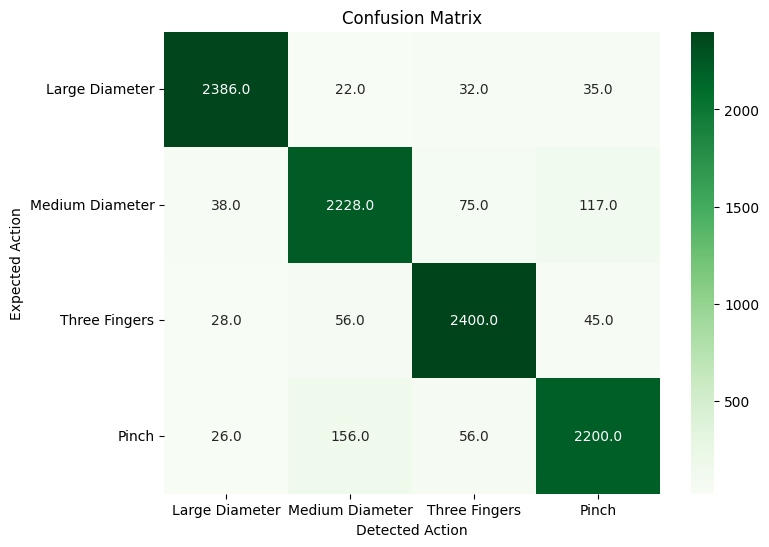

In [18]:
y_pred = model(torch.tensor(test_data).float().to(device)).argmax(1)
y_true = torch.tensor(test_labels).to(device)
# Initialize confusion matrix metric and move it to the same device as the model
conf_matrix_metric = MulticlassConfusionMatrix(num_classes=number_gestures).to(device)
# Compute confusion matrix
conf_matrix = conf_matrix_metric(y_pred, y_true)
# Move confusion matrix to CPU for visualization
conf_matrix = conf_matrix.cpu().numpy()
print(conf_matrix)

actions = ["Large Diameter", "Medium Diameter", "Three Fingers", "Pinch"]

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Greens", xticklabels=actions, yticklabels=actions)

# Labels and title
plt.xlabel("Detected Action")
plt.ylabel("Expected Action")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# 6. Number of Parameters

In [19]:
number_of_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The number of parameters is {number_of_parameters}')

The number of parameters is 232036
